In [2]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 
import pandas as pd
from coffea.lookup_tools import extractor

In [3]:
from HNLprocessor.HNLproc_4 import *

In [4]:
events_sig =  uproot.lazy("/uscms/home/kkwok/lpclonglived/HNL/skim/HNL_muonType_mHNL4p0_pl1000/HeavyNeutralLepton_Tree_1.root:MuonSystem")

In [ ]:
basedir="/uscms/home/jschindl/nobackup/HNL/LLP_coffea/metadata/muonefficiencies/Run2/preUL/"
ext = extractor()
year=2018
ext.add_weight_sets([f'muon_ID_2018_value NUM_TightID_DEN_TrackerMuons_pt_abseta {basedir}/2018/2018_Z/RunABCD_SF_ID.root'])
ext.add_weight_sets([f'muon_ID_2018_error NUM_TightID_DEN_TrackerMuons_pt_abseta_error {basedir}/2018/2018_Z/RunABCD_SF_ID.root'])

ext.add_weight_sets([f'muon_ISO_2018_value NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta {basedir}/2018/2018_Z/RunABCD_SF_ISO.root'])
ext.add_weight_sets([f'muon_ISO_2018_error NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta_error {basedir}/2018/2018_Z/RunABCD_SF_ISO.root'])

ext.add_weight_sets([f'muon_trigger_2018_value IsoMu24_PtEtaBins/efficienciesDATA/abseta_pt_DATA {basedir}/2018/2018_trigger/EfficienciesAndSF_2018Data_BeforeMuonHLTUpdate.root'])
ext.add_weight_sets([f'muon_trigger_2018_error IsoMu24_PtEtaBins/efficienciesDATA/abseta_pt_DATA_error {basedir}/2018/2018_trigger/EfficienciesAndSF_2018Data_BeforeMuonHLTUpdate.root'])

ext.finalize()
lepsf_evaluator = ext.make_evaluator()
lepsf_keys = lepsf_evaluator.keys()

def add_muonSFs(weights, leadingmuon, year, selection):
    def mask(w):
        return np.where(selection.all('good_lepton'), w, 1.)

    yeartag = year

    for sf in lepsf_keys:

        if yeartag not in sf:
            continue
        if 'muon' not in sf:
            continue

        lep_pt = np.array(ak.fill_none(leadingmuon.pt, 0.))
        lep_eta = np.array(ak.fill_none(leadingmuon.eta, 0.))

        if 'value' in sf:
            
            nom = lepsf_evaluator[sf](np.abs(lep_eta),lep_pt)
            shift = lepsf_evaluator[sf.replace('_value','_error')](np.abs(lep_eta),lep_pt)
            print(sf)
            print(nom)
            print(shift)
            weights.add(sf, nom, shift, shift=True)

In [7]:
def run_processor(events_sig,signal=True):
    
    isData=False
    isSignal=True
    dataset = "HNL_muonType_mHNL4p0_pl1000"
    p = MyProcessor(isElectronChannel=False)  
    output = p.accumulator.identity()  ## get from histograms
    llp      = p.buildLLP(events_sig)
    good_lep,ele,muons = p.buildGoodLeptons(events_sig)
    cluster = p.buildCSCcluster(events_sig,good_lep)
    dt_cluster = p.buildDTcluster(events_sig,good_lep)

    clusterMasks = p.selectCSCcluster(cluster,events_sig)
    dt_clusterMasks = p.selectDTcluster(dt_cluster,events_sig)

    CSC_sel_ABCD = ["ME11_12_veto","jetVeto","muonVeto","MB1seg_veto","RB1_veto",
                        "IntimeCut","timeSpreadCut","ClusterID"]
    DT_sel_ABCD = ["dt_MB1veto","dt_jetVeto","dt_muonVeto","dt_RPC","dt_MB1adj","dt_time",
                  ]

    selectionMasks =   {}
    selectionMasks['Acceptance_dt']=ak.firsts(events_sig.gLLP_dt)==1
    selectionMasks['trigger_ele']  =events_sig.SingleEleTrigger==True
    selectionMasks['trigger_mu']   =events_sig.SingleMuonTrigger==True
    selectionMasks['good_lepton']  =ak.num(good_lep,axis=1)==1
    selectionMasks['MET']          =events_sig.metEENoise>=30
    selectionMasks['METfilters']   =events_sig.Flag2_all==True

    selectionMasks['dt_cls_ABCD']  = buildMask(dt_clusterMasks,DT_sel_ABCD)
    selectionMasks['cls_ABCD']  = buildMask(clusterMasks,CSC_sel_ABCD)
    preselections = ['trigger_mu','MET',"METfilters",'good_lepton']
    if signal:
        preselections = ['trigger_mu','MET',"METfilters",'good_lepton','Acceptance_dt']
    regions = {
        "PreSel_dt"       :preselections,
        "ABCD_dt"      :preselections+["dt_cls_ABCD"],            

    }
    for region,cutnames in regions.items():
            print(region)
            print(cutnames)
            ## Fill other regions without cutflows
            #cut = buildMask(selectionMasks,cutnames)
    weights = Weights(len(events_sig),storeIndividual=True)
    if not isData:
        corrections.add_pileup_weight(weights, events_sig.npu,'2018')
        corrections.add_Wpt_kfactor(weights, events_sig.gWPt, dataset)
        if isSignal and "rwctau" in dataset:
            ## expect dataset = "HNL_*_pl{ctau_old}_rwctau{ctau_new}"
            ctau_old =  float(dataset.split("_")[-2].replace("pl",""))/10     ##ctau in dataset name is in mm
            ctau_new =  float(dataset.split("_")[-1].replace("rwctau",""))/10 ##new ctau needs to be in cm
            corrections.add_ctau_weight(weights, llp.ctau, ctau_old, ctau_new)
        #add_muonSFs(weights, leadingmuon, year, selection)
        add_muonSFs(weights, ak.firsts(muons), "2018", selectionMasks)
        pass
    systematics = list(weights.variations)
    cut = buildMask(selectionMasks,regions["PreSel_dt"])
    if cut.ndim==1:
        ev_cut = cut                  ##This is a per-event cut
    else:
        ev_cut = ak.any(cut,axis=1)   ##This is a per-cluster cut, require at least 1 passing cluster
    
    output['muPt'].fill(dataset=dataset , muPt  = ak.flatten(muons.pt) )
    output['muPt_sys'].fill(dataset=dataset ,Sys="Nominal", muPt  = ak.flatten(muons[ev_cut].pt),weight=weights.weight()[ev_cut])
    for i in systematics:
        output['muPt_sys'].fill(dataset=dataset ,Sys=str(i), muPt  = ak.flatten(muons[ev_cut].pt),weight=weights.weight(modifier=i)[ev_cut])
        
    output= p.postprocess(output)
    return dt_cluster, ev_cut, muons, weights, output
dt_cluster_sig, evt_cut_sig, muons, weights, output = run_processor(events_sig,signal=True)

PreSel_dt
['trigger_mu', 'MET', 'METfilters', 'good_lepton', 'Acceptance_dt']
ABCD_dt
['trigger_mu', 'MET', 'METfilters', 'good_lepton', 'Acceptance_dt', 'dt_cls_ABCD']
muon_ID_2018_value
[0.98001127 0.9894084  0.98001127 ... 0.98001127 0.9894084  0.98001127]
[0.00355718 0.00210046 0.00355718 ... 0.00355718 0.00210046 0.00355718]
muon_ISO_2018_value
[1.08817058 0.98083427 1.08817058 ... 1.08817058 0.98083427 1.08817058]
[0.00661688 0.00631073 0.00661688 ... 0.00661688 0.00631073 0.00661688]
muon_trigger_2018_value
[0.6818621  0.8900847  0.88079304 ... 0.8427144  0.8900847  0.8041993 ]
[0.00249751 0.00077066 0.00063185 ... 0.0004202  0.00077066 0.0012834 ]


In [34]:
for k,h in output.items():
    print(k)

    
output = postprocess(output)

cutflow
nCluster
nCluster_dt
nCluster_n-1
accept
ClusterSize
ClusterTime
ClusterEta
ClusterAvgStation10
ClusterNStation10
dphi_cluster_csc
dr_lep_and_dphi_lep
ClusterEta_dt
ClusterAvgStation10_dt
ClusterNStation10_dt
dr_lep_and_dphi_lep_dt
dphi_cluster_dt
ClusterID_dt
ClusterEta_dt_dphi_lep
ClusterAvgStation10_dt_dphi_lep
ClusterNStation10_dt_dphi_lep
ClusternMB1
Cluster_MuonVeto_Pt_dt
Cluster_MuonVeto_Eta_dt
Cluster_MuonVeto_Phi_dt
ClusterID_csc
ClusterSize_dt
ClusterTime_dt
ClusterMaxStationRatio_dt
nLeptons
DiMuonMass
elePt
eleEta
muPt
muPt_sys
muEta
nJets
jetPt
jetMet_dPhi
metXYCorr
MT
weight_histo
nPU
nPU_noweight
gWPt
gWPt_noweight
gLepPhi
gLepPt
gLepEta
gLLP_e
gLLP_pt
gLLP_eta
llp_cls_z
llp_cls_eff_z
llp_cls_eff_r
llp_cls_eff_e
llp_cls_dt_eff_z
llp_cls_dt_eff_r
llp_cls_dt_eff_e
sumw


TypeError: postprocess() missing 1 required positional argument: 'accumulator'

{('Nominal',): array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       17.02494108, 16.32744679, 31.43595538, 25.96787728, 37.04538134,
       36.9715343 , 29.07077397, 25.69035511, 11.01546393,  3.91074546,
        3.75827372,  4.3726817 ,  0.31923175,  4.09933457,  2.82806204,
       10.46989972,  0.        ,  4.29388634,  0.        ,  1.48169595,
        1.31497058,  0.66059721,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]), ('muon_ID_2018_valueUp',): array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       17.08673712, 16.38671111, 31.5500596 , 26.06213382, 37.1798463 ,
       37.10573122, 29.17629321, 25.78360431, 11.05544716,  3.92494043,
        3.77191526,  4.38855338,  0.32039048,  4.11421408,  2.83832716,
       10.50790269, 

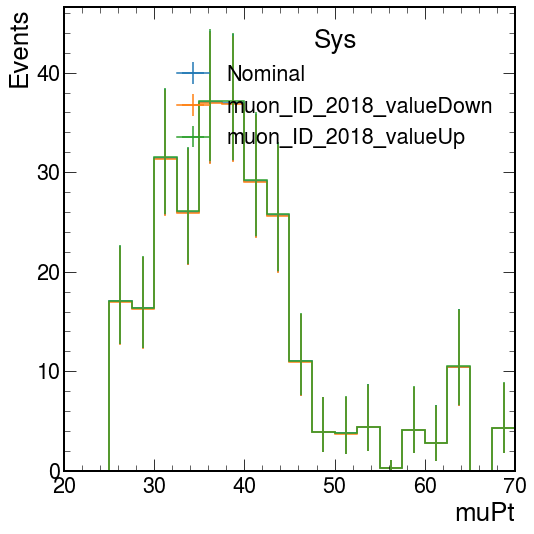

In [45]:

h = output['muPt_sys']

#h = h.integrate("Sys",["nominal","muon_ID_2018_valueDown","muon_ID_2018_valueUp"])
h = h.integrate("dataset",'HNL_muonType_mHNL4p0_pl1000')

plt.style.use(hep.style.CMS) 

fig, axs = plt.subplots(1,1, figsize=(8,8))
print(h[["Nominal","muon_ID_2018_valueDown","muon_ID_2018_valueUp"]].values())
#axs = axs.flatten()

hist.plot1d(h[["Nominal","muon_ID_2018_valueDown","muon_ID_2018_valueUp"]],ax=axs)
#axs.set_yscale("log")

axs.set_xlim(20,70)
plt.tight_layout()

<Hist (Sys,muPt) instance at 0x7f19caa21b90>


/uscms/home/jschindl/work/LLP/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/jschindl/work/LLP/coffeaenv/lib/python3.7/site-packages/coffea/hist/plot.py:439: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:881: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


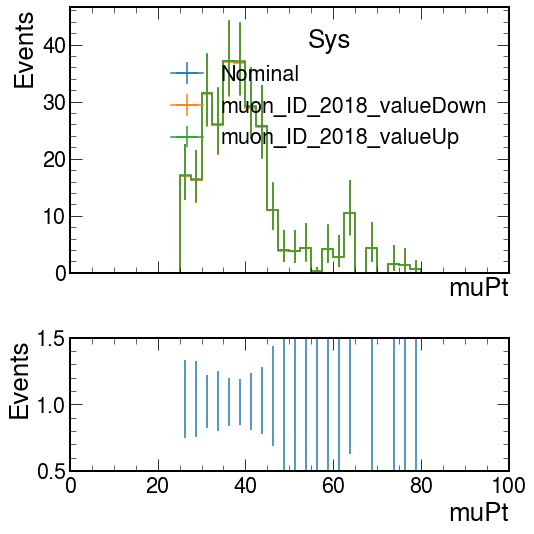

In [8]:


h = output['muPt_sys']

#h = h.integrate("Sys",["nominal","muon_ID_2018_valueDown","muon_ID_2018_valueUp"])
h = h.integrate("dataset",'HNL_muonType_mHNL4p0_pl1000')

plt.style.use(hep.style.CMS) 
fig, axs = plt.subplots(2,1, figsize=(8,8),gridspec_kw={"height_ratios":[2,1]},sharex=True)

axs = axs.flatten()

hist.plot1d(h[["Nominal","muon_ID_2018_valueDown","muon_ID_2018_valueUp"]],ax=axs[0])
print(h["Nominal",])
hist.plotratio(h.integrate("Sys","Nominal"), 
               h.integrate("Sys","muon_ID_2018_valueDown"),unc="num",ax=axs[1],
               denom_fill_opts=None,error_opts="")
#axs.set_yscale("log")

axs[1].set_ylim(0.5,1.5)
plt.tight_layout()

In [80]:
print(list(weights.variations))
print(weights.weight())
print(ak.where(weights.partial_weight(include="pileup_weightUp")!=1))
print(weights.weight(modifier="muon_ID_2018_valueDown"))

['muon_trigger_2018_valueDown', 'muon_ID_2018_valueDown', 'muon_trigger_2018_valueUp', 'muon_ISO_2018_valueDown', 'muon_ID_2018_valueUp', 'muon_ISO_2018_valueUp', 'pileup_weightDown', 'pileup_weightUp']
[0.56843935 0.55863025 1.38008349 ... 1.24797065 1.07298295 0.81009454]
(<Array [] type='0 * int64'>,)
[0.56638353 0.55744682 1.37509227 ... 1.24345723 1.07070989 0.80716475]


In [29]:
muons.pt
ep_pt = np.array(ak.fill_none(ak.firsts(muons.pt), 0.))

In [14]:
basedir="/uscms/home/jschindl/nobackup/HNL/LLP_coffea/metadata/muonefficiencies/Run2/preUL/"
ext = extractor()
year=2018
ext.add_weight_sets([f'muon_ID_2018_value NUM_TightID_DEN_TrackerMuons_pt_abseta {basedir}/2018/2018_Z/RunABCD_SF_ID.root'])
ext.add_weight_sets([f'muon_ID_2018_error NUM_TightID_DEN_TrackerMuons_pt_abseta_error {basedir}/2018/2018_Z/RunABCD_SF_ID.root'])

ext.add_weight_sets([f'muon_ISO_2018_value NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta {basedir}/2018/2018_Z/RunABCD_SF_ISO.root'])
ext.add_weight_sets([f'muon_ISO_2018_error NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta_error {basedir}/2018/2018_Z/RunABCD_SF_ISO.root'])

ext.add_weight_sets([f'muon_trigger_2018_value IsoMu24_PtEtaBins/efficienciesDATA/abseta_pt_DATA {basedir}/2018/2018_trigger/EfficienciesAndSF_2018Data_BeforeMuonHLTUpdate.root'])
ext.add_weight_sets([f'muon_trigger_2018_error IsoMu24_PtEtaBins/efficienciesDATA/abseta_pt_DATA_error {basedir}/2018/2018_trigger/EfficienciesAndSF_2018Data_BeforeMuonHLTUpdate.root'])

ext.finalize()
lepsf_evaluator = ext.make_evaluator()
lepsf_keys = lepsf_evaluator.keys()

In [12]:
ext = extractor()
# several histograms can be imported at once using wildcards (*)
ext.add_weight_sets(["* * ../metadata/muonefficiencies/Run2/preUL//2018/2018_trigger/EfficienciesAndSF_2018Data_BeforeMuonHLTUpdate.root"])
ext.finalize()
evaluator = ext.make_evaluator()

print("available evaluator keys:")
for key in evaluator.keys():
    print("\t", key)

available evaluator keys:
	 IsoMu24_EtaBins/efficienciesDATA/histo_eta_DATA
	 IsoMu24_EtaBins/efficienciesDATA/histo_eta_DATA_error
	 IsoMu24_EtaBins/efficienciesMC/histo_eta_MC
	 IsoMu24_EtaBins/efficienciesMC/histo_eta_MC_error
	 IsoMu24_EtaBins/eta_ratio
	 IsoMu24_EtaBins/eta_ratio_error
	 IsoMu24_PtBins/efficienciesDATA/histo_pt_DATA
	 IsoMu24_PtBins/efficienciesDATA/histo_pt_DATA_error
	 IsoMu24_PtBins/efficienciesMC/histo_pt_MC
	 IsoMu24_PtBins/efficienciesMC/histo_pt_MC_error
	 IsoMu24_PtBins/pt_ratio
	 IsoMu24_PtBins/pt_ratio_error
	 IsoMu24_PtEtaBins/efficienciesDATA/abseta_pt_DATA
	 IsoMu24_PtEtaBins/efficienciesDATA/abseta_pt_DATA_error
	 IsoMu24_PtEtaBins/efficienciesDATA/pt_abseta_DATA
	 IsoMu24_PtEtaBins/efficienciesDATA/pt_abseta_DATA_error
	 IsoMu24_PtEtaBins/efficienciesMC/abseta_pt_MC
	 IsoMu24_PtEtaBins/efficienciesMC/abseta_pt_MC_error
	 IsoMu24_PtEtaBins/efficienciesMC/pt_abseta_MC
	 IsoMu24_PtEtaBins/efficienciesMC/pt_abseta_MC_error
	 IsoMu24_PtEtaBins/abseta_pt_

In [7]:
from coffea.lookup_tools import extractor

In [42]:
ext = extractor()
# several histograms can be imported at once using wildcards (*)
ext.add_weight_sets(["* * ../metadata/muonefficiencies/Run2/preUL//2018/2018_Z/RunABCD_SF_ISO.root"])
ext.finalize()

evaluator = ext.make_evaluator()

print("available evaluator keys:")
for key in evaluator.keys():
    print("\t", key)


available evaluator keys:
	 NUM_TightRelIso_DEN_MediumID_pt_abseta
	 NUM_TightRelIso_DEN_MediumID_pt_abseta_error
	 NUM_TightRelIso_DEN_MediumID_pt_abseta_stat
	 NUM_TightRelIso_DEN_MediumID_pt_abseta_stat_error
	 NUM_TightRelIso_DEN_MediumID_pt_abseta_syst
	 NUM_TightRelIso_DEN_MediumID_pt_abseta_syst_error
	 NUM_LooseRelIso_DEN_MediumID_pt_abseta
	 NUM_LooseRelIso_DEN_MediumID_pt_abseta_error
	 NUM_LooseRelIso_DEN_MediumID_pt_abseta_stat
	 NUM_LooseRelIso_DEN_MediumID_pt_abseta_stat_error
	 NUM_LooseRelIso_DEN_MediumID_pt_abseta_syst
	 NUM_LooseRelIso_DEN_MediumID_pt_abseta_syst_error
	 NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta
	 NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta_error
	 NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta_stat
	 NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta_stat_error
	 NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta_syst
	 NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta_syst_error
	 NUM_LooseRelIso_DEN_LooseID_pt_abseta
	 NUM_LooseRelIso_DEN_LooseID_pt_abseta_

In [39]:
ext = extractor()
# several histograms can be imported at once using wildcards (*)
ext.add_weight_sets(["* * ../metadata/muonefficiencies/Run2/preUL//2016/2016_Z/RunBCDEF_SF_ISO.root"])
ext.finalize()

evaluator = ext.make_evaluator()

print("available evaluator keys:")
for key in evaluator.keys():
    print("\t", key)

available evaluator keys:
	 NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt
	 NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt_error
	 NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt_stat
	 NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt_stat_error
	 NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt_syst
	 NUM_LooseRelTkIso_DEN_HighPtIDandIPCut_eta_pair_newTuneP_probe_pt_syst_error
	 NUM_TightRelIso_DEN_MediumID_eta_pt
	 NUM_TightRelIso_DEN_MediumID_eta_pt_error
	 NUM_TightRelIso_DEN_MediumID_eta_pt_stat
	 NUM_TightRelIso_DEN_MediumID_eta_pt_stat_error
	 NUM_TightRelIso_DEN_MediumID_eta_pt_syst
	 NUM_TightRelIso_DEN_MediumID_eta_pt_syst_error
	 NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt
	 NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt_error
	 NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt_stat
	 NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt_stat_error
	 NUM_TightRelIso_DEN_TightIDandIPCut_eta_pt_syst
	 NUM_Tigh

In [ ]:
ext = extractor()
ext.add_weight_sets([
    "* * data/Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi.jec.txt",
    "* * data/Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi.junc.txt",
])
ext.finalize()